In [19]:
# 📘 1. 데이터 불러오기 및 전처리
import pandas as pd

df = pd.read_csv("C:/Users/m/OneDrive - 계명대학교/25-1학기/sas viya/TRAIN_DATA.csv", encoding='cp949')
df['YEAR'] = df['DATA_YM'].astype(str).str[:4].astype(int)
df['MONTH'] = df['DATA_YM'].astype(str).str[4:].astype(int)
df = df.dropna(subset=['TOTAL_ELEC']).copy()


In [20]:
# 📘 2. FLAML으로 전체 학습 → 중요 변수 추출
from flaml import AutoML

excluded = ['DATA_YM', 'AREA_ID', 'AREA_NM', 'DIST_NM']
target_col = 'TOTAL_ELEC'
feature_cols = [col for col in df.columns if col not in excluded + [target_col]]

X = df[feature_cols]
y = df[target_col]

automl = AutoML()
automl.fit(
    X_train=X,
    y_train=y,
    task="regression",
    time_budget=300,
    verbose=0
)

# 중요 변수 상위 2개 추출 (지역코드 제외)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': automl.feature_importances_
}).sort_values(by='importance', ascending=False)

top2_features = [f for f in importance_df['feature'] if f not in ['DIST_CD', 'DIST_NM']][:2]
print(f"📌 클러스터링용 상위 변수: {top2_features}")


📌 클러스터링용 상위 변수: ['TOTAL_BIDG', 'FAC_NEIGH_2']


C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m\AppDa


✅ 최적 클러스터 수: 2


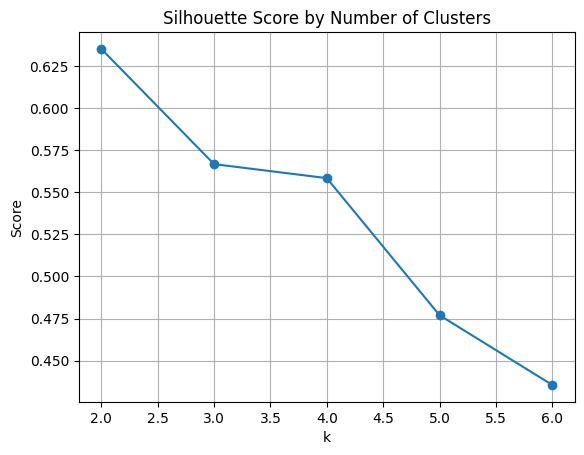

C:\Users\m\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
# 📘 3. 클러스터링 (상위 2개 변수 기준, silhouette score 기반 k 탐색)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[top2_features])

# 클러스터링 대상 데이터 준비
cluster_df = df.dropna(subset=top2_features).copy()
X_cluster = scaler.fit_transform(cluster_df[top2_features])

scores = {}
for k in range(2, 7):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_cluster)
    scores[k] = silhouette_score(X_cluster, labels)

best_k = max(scores, key=scores.get)
print(f"\n✅ 최적 클러스터 수: {best_k}")

plt.plot(list(scores.keys()), list(scores.values()), marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("k")
plt.ylabel("Score")
plt.grid(True)
plt.show()

# 클러스터 할당
df = df.dropna(subset=top2_features).copy()
X_cluster = scaler.fit_transform(df[top2_features])
df['cluster'] = KMeans(n_clusters=best_k, random_state=42).fit_predict(X_cluster)



In [30]:
# 📘 4. 클러스터별 AutoML (FLAML 내부 CV 기반 평가)
from sklearn.metrics import mean_squared_error
import joblib, json, os

os.makedirs("models", exist_ok=True)
results = []

for cluster_id in sorted(df['cluster'].unique()):
    print(f"\n[CLUSTER {cluster_id}] AutoML + CV 시작")

    cluster_data = df[df['cluster'] == cluster_id].copy()
    X_cluster = cluster_data[feature_cols]
    y_cluster = cluster_data[target_col]

    automl = AutoML()
    automl.fit(
        X_train=X_cluster,
        y_train=y_cluster,
        task="regression",
        metric='rmse',       # RMSE 기준일 때
        time_budget=300,
        eval_method='cv',        # ✅ 내부 CV
        n_splits=5,
        verbose=0
    )

    results.append({
        "Cluster": cluster_id,
        "Samples": len(cluster_data),
        "Best_Model": automl.best_estimator,
        "Best_Params": automl.best_config,
        "CV_Score(RMSE)": automl.best_loss,  # RMSE 기준일 때
    })

    # 모델 저장
    joblib.dump(automl, f"models/automl_cluster_{cluster_id}.pkl")
    with open(f"models/params_cluster_{cluster_id}.json", "w") as f:
        json.dump(automl.best_config, f)



[CLUSTER 0] AutoML + CV 시작

[CLUSTER 1] AutoML + CV 시작


In [31]:
# 📘 5. 클러스터링 모델 저장
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(kmeans, "models/kmeans.pkl")


['models/kmeans.pkl']

In [32]:
# 📘 6. 결과 정리 출력
results_df = pd.DataFrame(results)
print("\n📊 클러스터별 AutoML (CV 기반) 결과")
print(results_df)



📊 클러스터별 AutoML (CV 기반) 결과
   Cluster  Samples      Best_Model  \
0        0    21230      extra_tree   
1        1     4866  xgb_limitdepth   

                                         Best_Params  CV_Score(RMSE)  
0  {'n_estimators': 318, 'max_features': 0.492027...      406.710611  
1  {'n_estimators': 553, 'max_depth': 10, 'min_ch...      328.583197  
